In [28]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



archive unpacked in ./


In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

# Starting from $\theta$

In [4]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1,
                 theta_factor=20):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        self.theta_factor = theta_factor
        
        self.register_buffer('target_thetas', self.theta_factor * target_distributions)
        self.target_thetas.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_thetas.shape[self.token_dim]
        self.batch_size = self.target_thetas.shape[self.batch_dim]
        self.n_dims = len(self.target_thetas.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_theta = torch.zeros_like(self.target_thetas)
            self.register_buffer('base_theta', base_theta)
        else:
            self.register_buffer('base_theta', baseline.view(self.target_thetas.shape))
        self.base_theta.requires_grad_()
        
    def rebatch(self, input):
        return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, theta):
        distribution = F.softmax(theta, dim=self.token_dim)
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, thetas):
        samples = self.get_samples(thetas).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = self.grad(predictions.sum(), inputs=thetas, retain_graph=True)[0]
        return gradients, predictions

    def get_point_theta(self, k):
        return self.base_theta + k * (self.target_thetas - self.base_theta)

    def integrate_gradients(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        line_gradients = []
        #for i in tqdm(range(num_steps + 1)):
        for i in range(0, num_steps + 1):
            slope = i / num_steps
            point_distribution = self.get_point_theta(slope)
            point_gradients, point_predictions = self.get_gradients(point_distribution)
            line_gradients.append(point_gradients)
            if i == 0:
                self.base_predictions = point_predictions.detach()
            elif i == num_steps:
                self.target_predictions = point_predictions.detach()
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=10, num_samples=20):
        #self.num_samples = num_samples
        gradients = self.integrate_gradients(num_steps, num_samples=num_samples).to(self.target_thetas.device)        
        salient_maps =  gradients * self.target_thetas
        return salient_maps.detach()

In [5]:
k562_predictor = mpra_predictor(model=model, pred_idx=0).cuda()
hepg2_predictor = mpra_predictor(model=model, pred_idx=1).cuda()
sknsh_predictor = mpra_predictor(model=model, pred_idx=2).cuda()

predictors = [k562_predictor, hepg2_predictor, sknsh_predictor]

In [6]:
main_df = pd.read_csv('gs://syrgoth/data/MPRA_ALL_no_cutoffs.txt', sep=" ", low_memory=False)

In [7]:
test_df = main_df[(main_df['chr'] == '7') | (main_df['chr'] == '13')].reset_index(drop=True)
test_df['seq_len'] = test_df.apply(lambda x: len(x['nt_sequence']), axis=1)

test_df_200 = test_df[test_df['seq_len'] == 200].reset_index(drop=True)
test_df_no_200 = test_df[test_df['seq_len'] != 200].reset_index(drop=True)

In [8]:
small_test_df_200 = test_df_200.sample(n=500, random_state=123)
test_distributions = df_to_onehot_tensor(small_test_df_200, seq_column='nt_sequence')
temp_dataset = TensorDataset(test_distributions)
temp_dataloader = DataLoader(temp_dataset, batch_size=50, shuffle=False, num_workers=2)

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
%%time
all_base_predictions = []
all_target_predictions = []
all_salient_maps = []
# batch_idx = 1
# total_batches = len(temp_dataloader)
for local_batch in tqdm(temp_dataloader):
# for local_batch in temp_dataloader:
#     print(f'Batch {batch_idx} / {total_batches}')
    batch_distributions = local_batch[0]
    attributers = [IntegratedSampledGradients(batch_distributions, predictor, theta_factor=15).cuda() for predictor in predictors]
#     salient_maps = []
#     for idx, predictor in enumerate(predictors):
#         salient_maps.append(attributers[idx].get_salient_maps(num_steps=50, num_samples=10).cpu())
    all_salient_maps.append([attributer.get_salient_maps(num_steps=50, num_samples=20).cpu() for attributer in attributers])  
    all_base_predictions.append([attributer.base_predictions.cpu() for attributer in attributers])
    all_target_predictions.append([attributer.target_predictions.cpu() for attributer in attributers])
    #all_salient_maps.append(salient_maps)
    #batch_idx +=1

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 30s, sys: 368 ms, total: 2min 30s
Wall time: 2min 29s


In [25]:
base_preds = torch.cat([torch.stack(base_predictions, dim=1) for base_predictions in all_base_predictions])
target_preds = torch.cat([torch.stack(target_predictions, dim=1) for target_predictions in all_target_predictions])

salient_map_tensor = torch.cat([torch.stack(salient_maps, dim=1) for salient_maps in all_salient_maps])
contribution_summations = salient_map_tensor.sum(dim=-1).sum(dim=-1).numpy()
pred_diffs = (target_preds - base_preds).numpy()

0.7942848615908937
0.7126163224652898


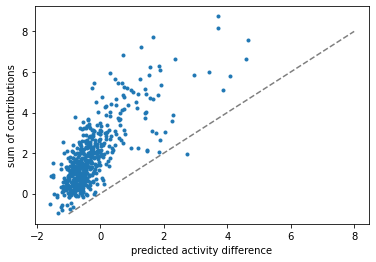

0.8641206792479857
0.8100234000936003


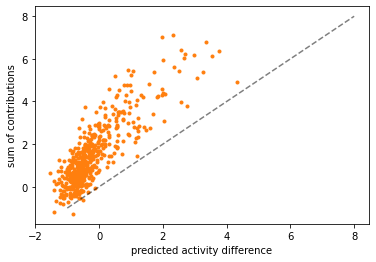

0.8760028114211607
0.7420877683510734


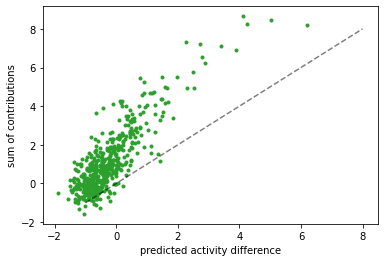

In [42]:
for cell_idx in range(3):

    print(stats.pearsonr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print(stats.spearmanr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    plt.scatter(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
    plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
    plt.ylabel('sum of contributions')
    plt.xlabel('predicted activity difference')
    plt.show()

0.7675349964791985
0.7126163224652898


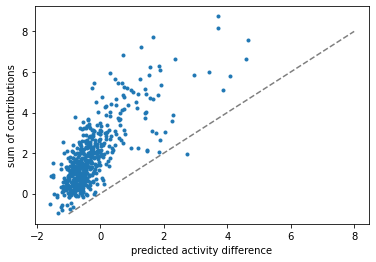

0.84872789100195
0.8100234000936003


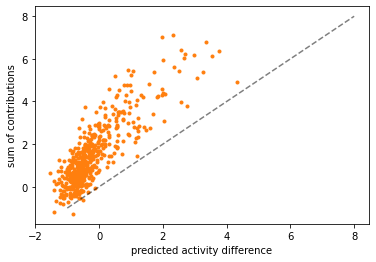

0.8514945746408121
0.7420877683510734


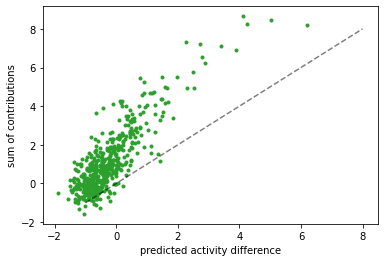

In [26]:
for cell_idx in range(3):

    print(stats.pearsonr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print(stats.spearmanr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    plt.scatter(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
    plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
    plt.ylabel('sum of contributions')
    plt.xlabel('predicted activity difference')
    plt.show()

0.7778992131930115
0.7189552278209113


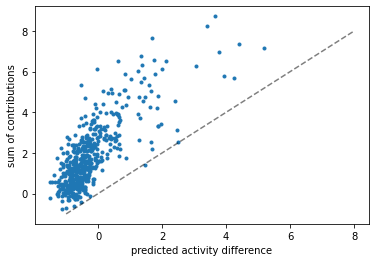

0.8560894625981138
0.7975201180804722


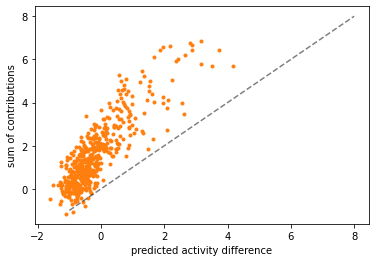

0.8510779463196124
0.751500414001656


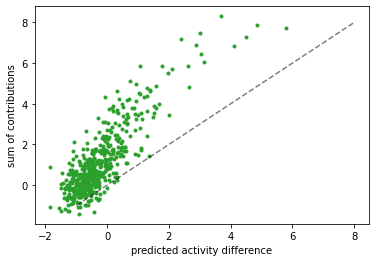

In [13]:
for cell_idx in range(3):

    print(stats.pearsonr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print(stats.spearmanr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    plt.scatter(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
    plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
    plt.ylabel('sum of contributions')
    plt.xlabel('predicted activity difference')
    plt.show()

tensor(0.4237)


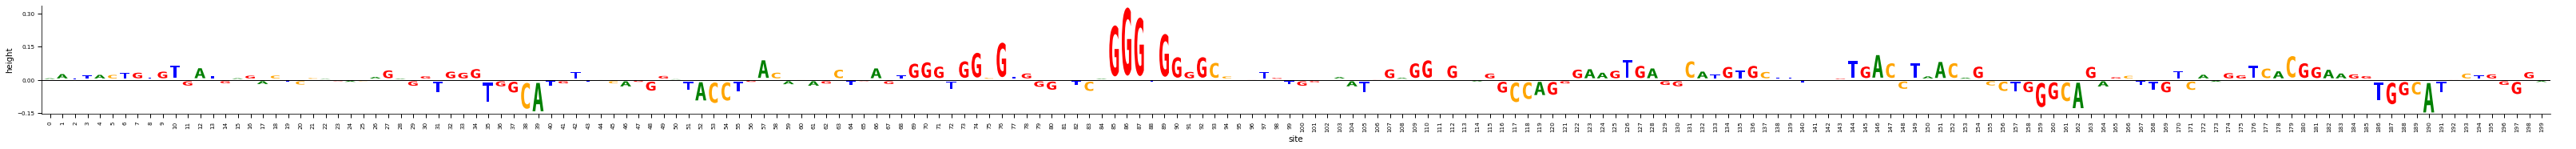

tensor(1.0345)


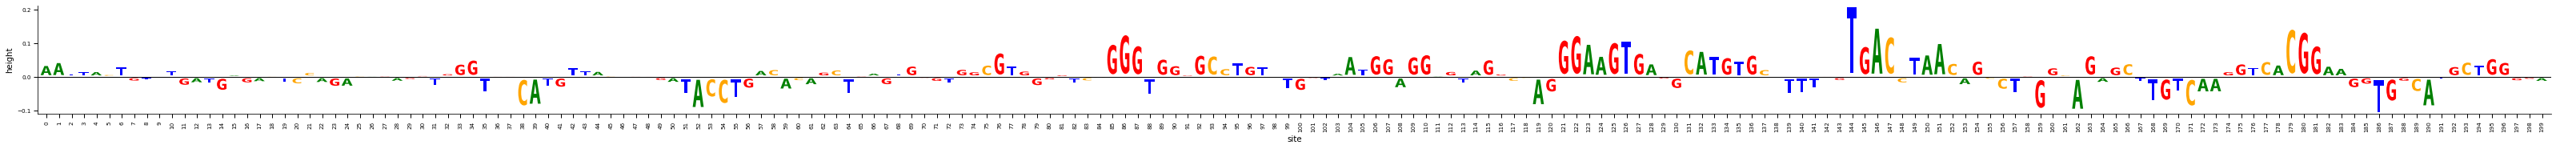

tensor(0.3288)


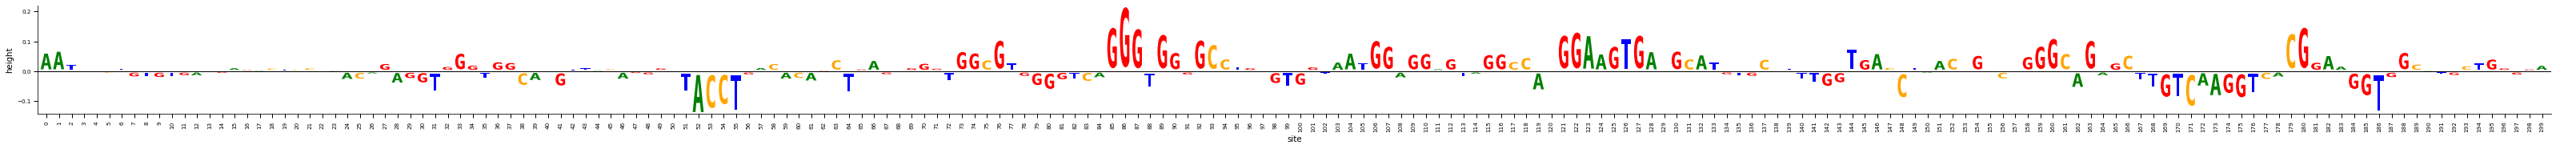

In [45]:
random_idx = random.randrange(500)
for i in range(3):
    print(target_preds[random_idx,i,...])
    matrix = salient_map_tensor[random_idx,i,...]
    y_max = matrix.max()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=1)
    plt.show()

## Explore with designed sequences

In [47]:
def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

In [48]:
k562_batch = fasta_to_tensor('K562_first_round__simulated_annealing.fa')
hepg2_batch = fasta_to_tensor('HepG2_first_round__simulated_annealing.fa')

In [61]:
batch = hepg2_batch[:20, ...]

predictors = [k562_predictor, hepg2_predictor, sknsh_predictor]

attributers = [IntegratedSampledGradients(batch, predictor, theta_factor=15).cuda() for predictor in predictors]
all_predictions = []
all_salient_maps = []
for idx, predictor in enumerate(predictors):
    all_predictions.append(predictor(batch.cuda()))
    all_salient_maps.append(attributers[idx].get_salient_maps(num_steps=50, num_samples=20).cpu())


------------------------------ Sequence 1 ------------------------------



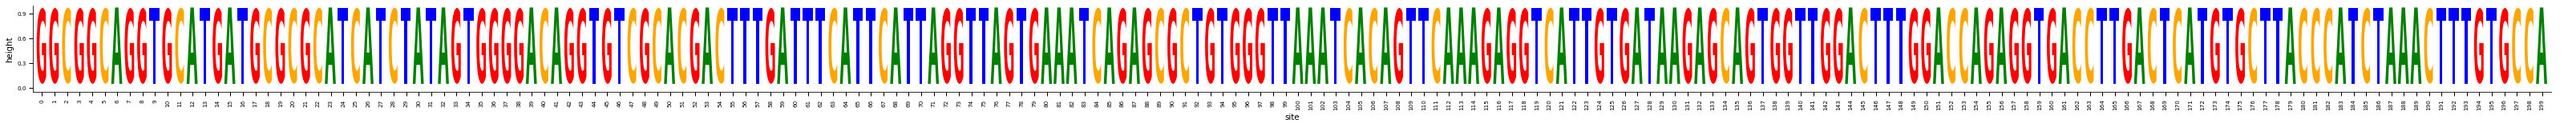

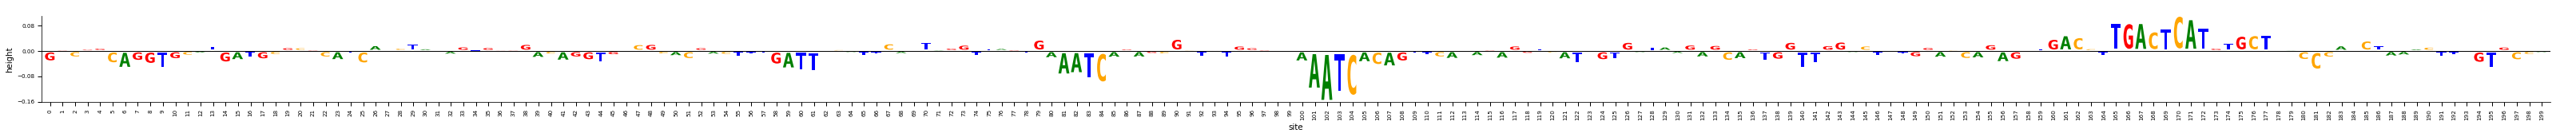

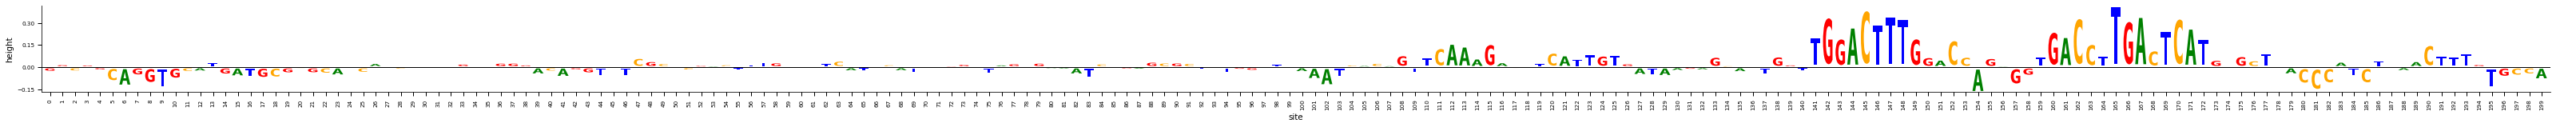

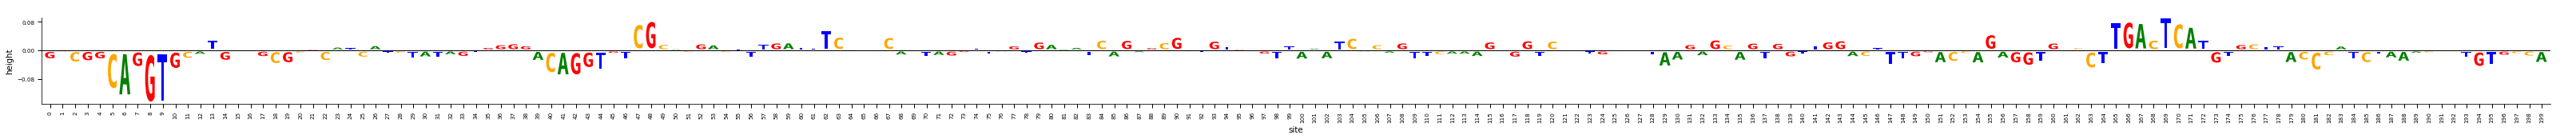


------------------------------ Sequence 2 ------------------------------



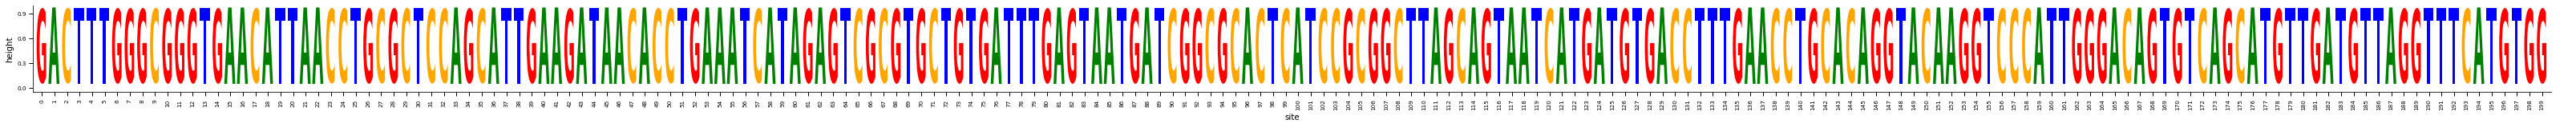

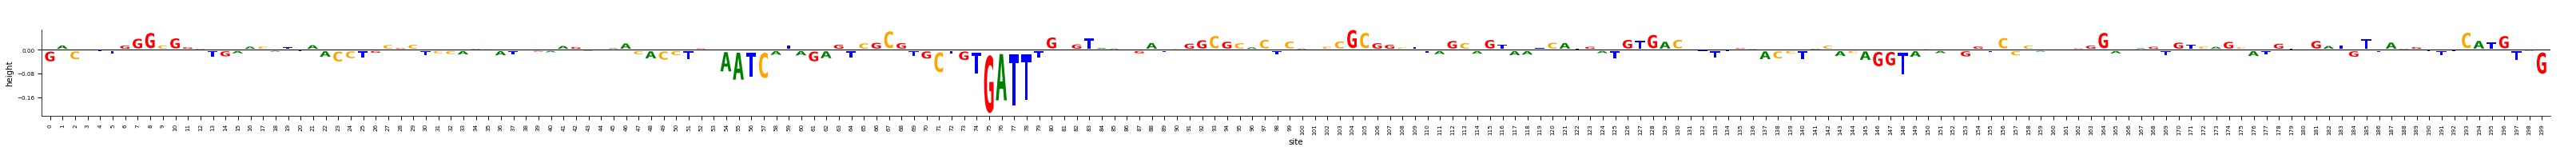

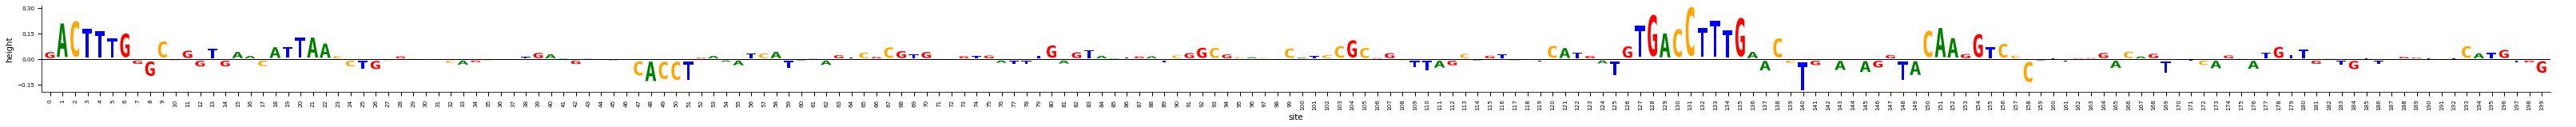

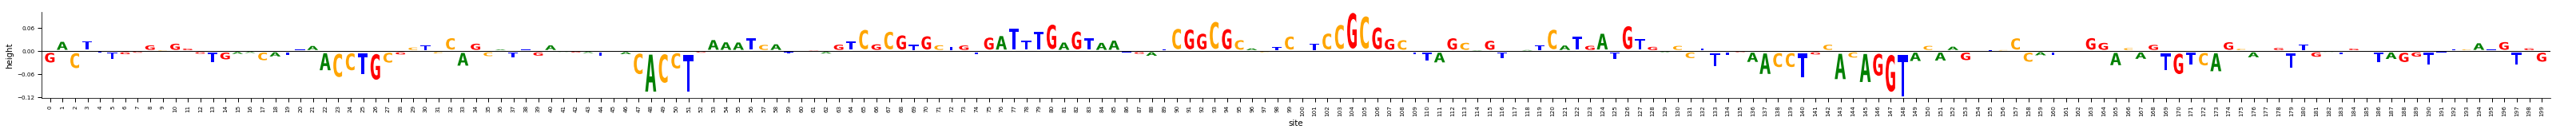


------------------------------ Sequence 3 ------------------------------



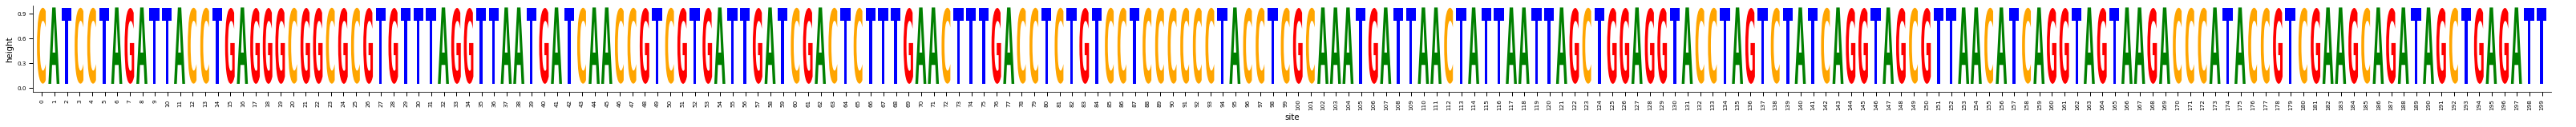

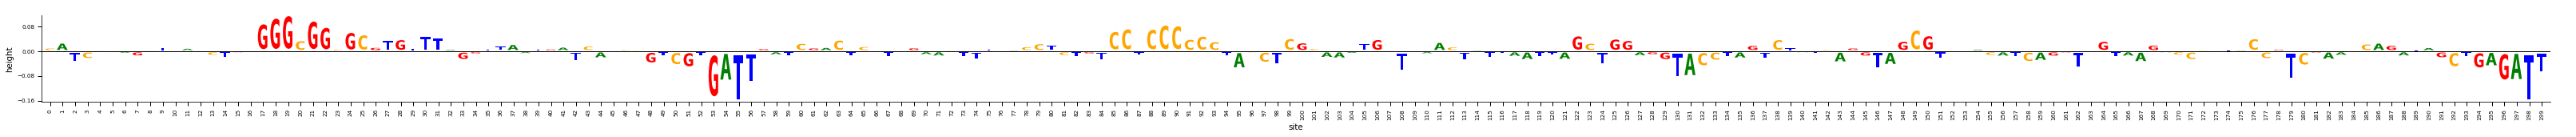

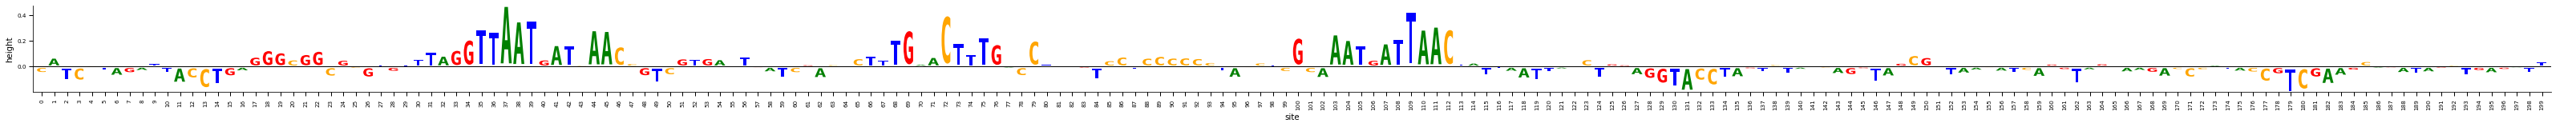

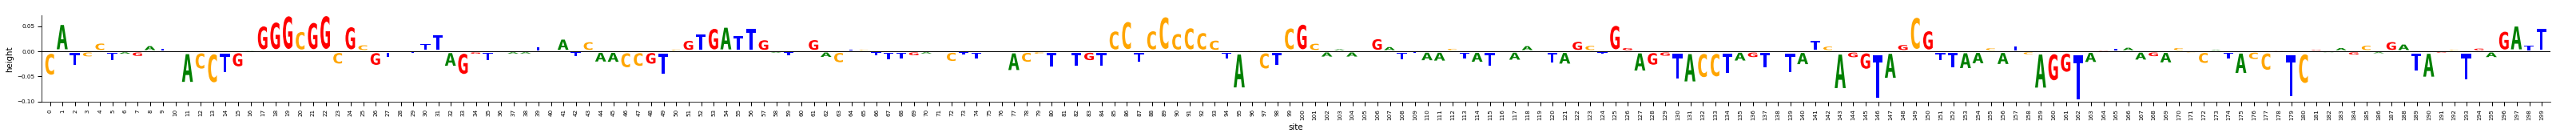


------------------------------ Sequence 4 ------------------------------



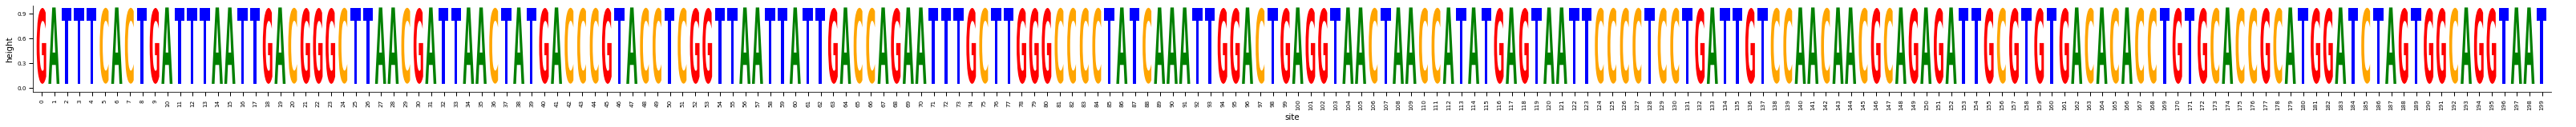

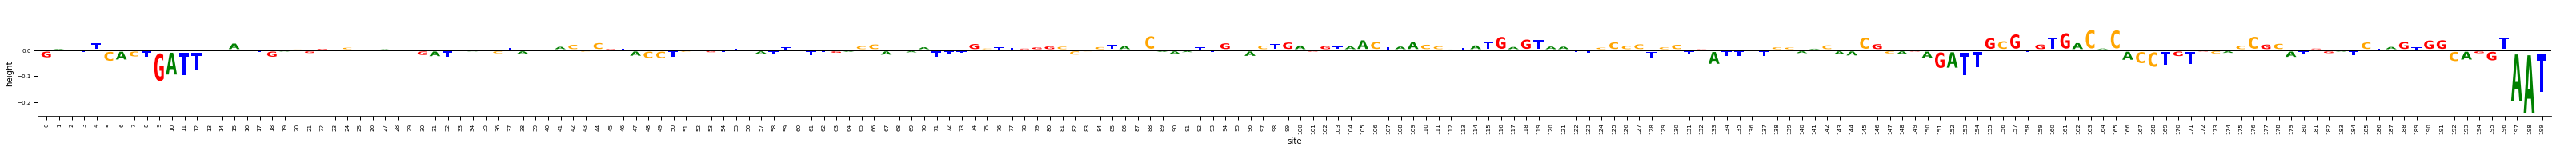

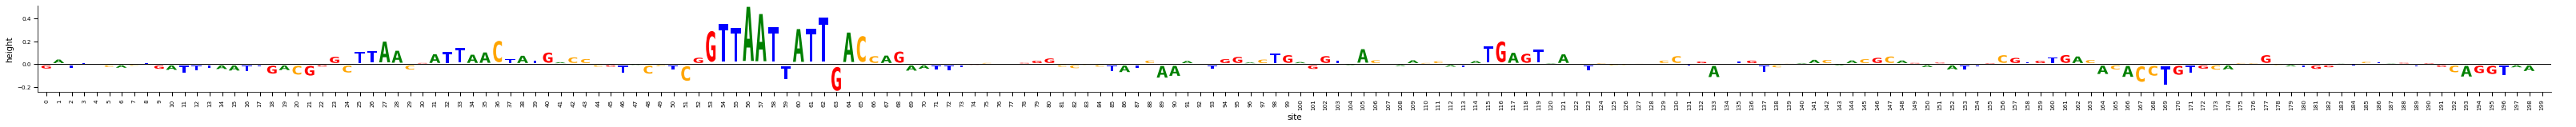

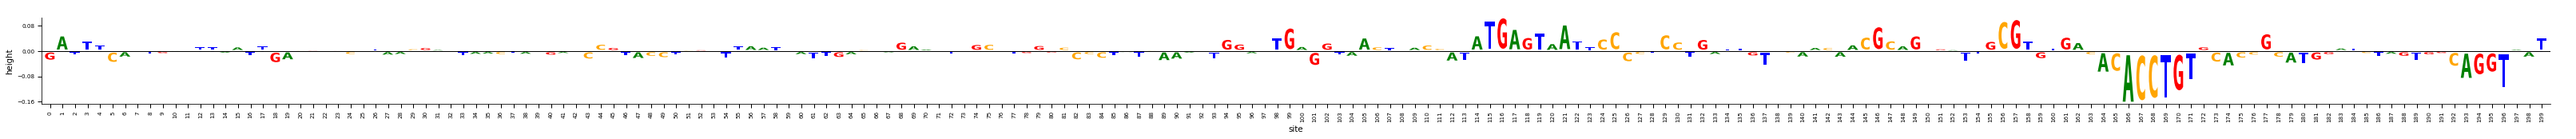


------------------------------ Sequence 5 ------------------------------



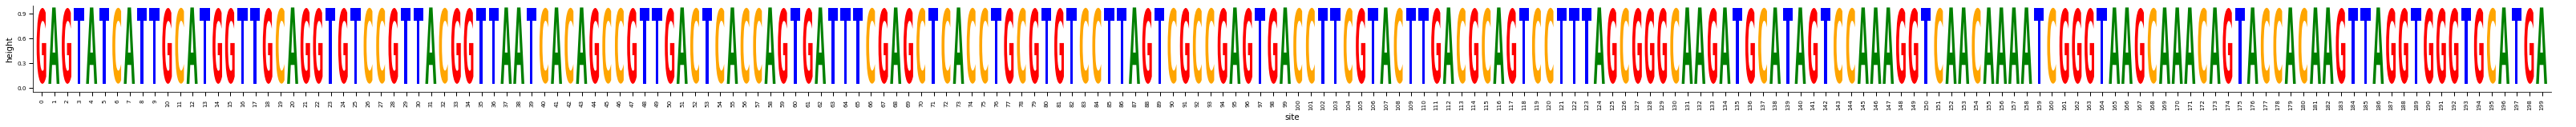

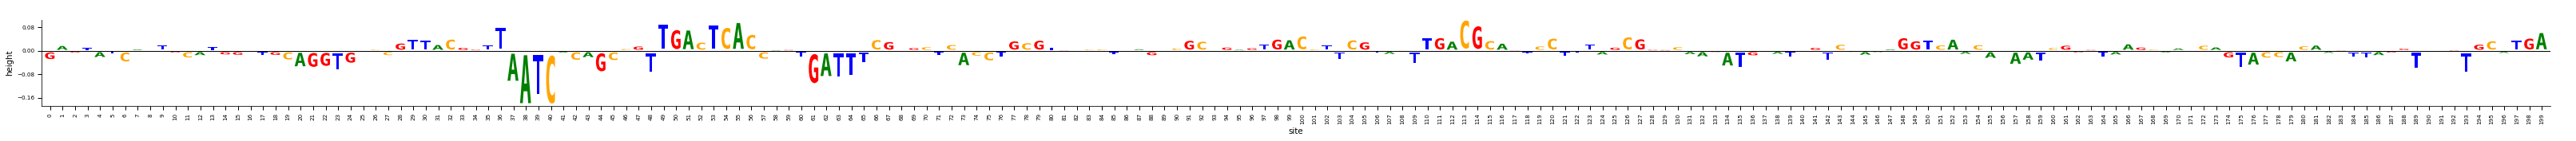

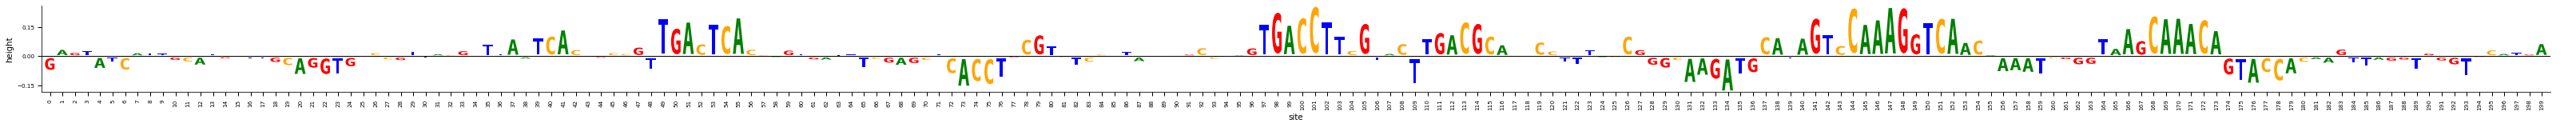

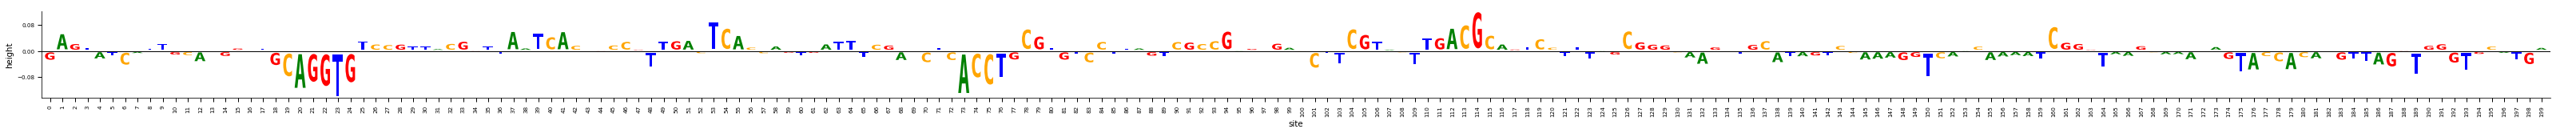


------------------------------ Sequence 6 ------------------------------



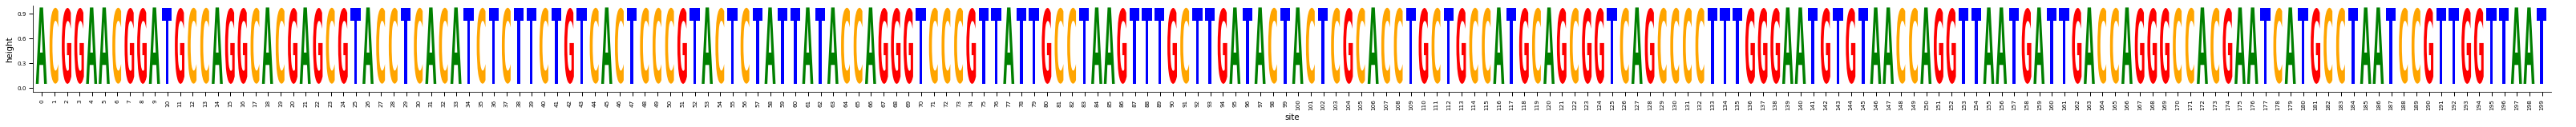

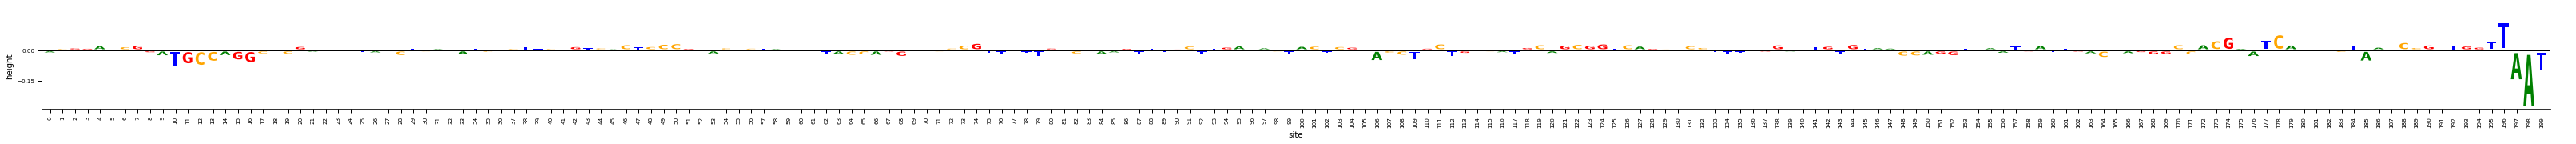

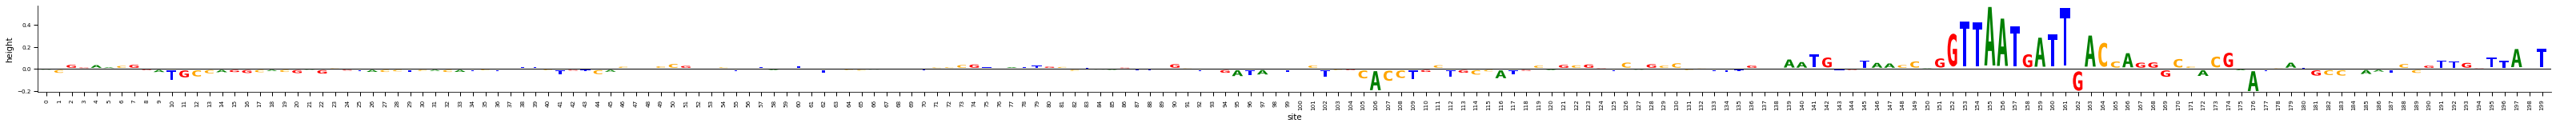

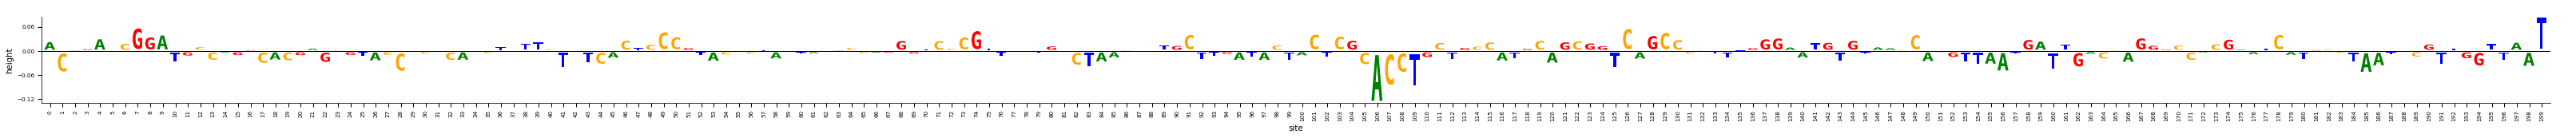


------------------------------ Sequence 7 ------------------------------



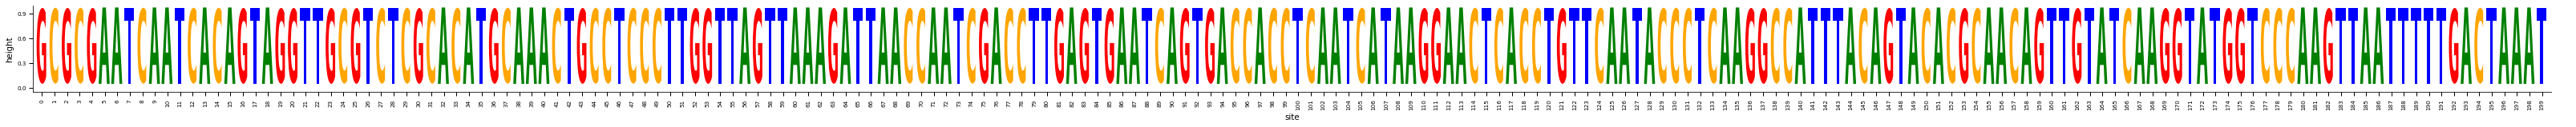

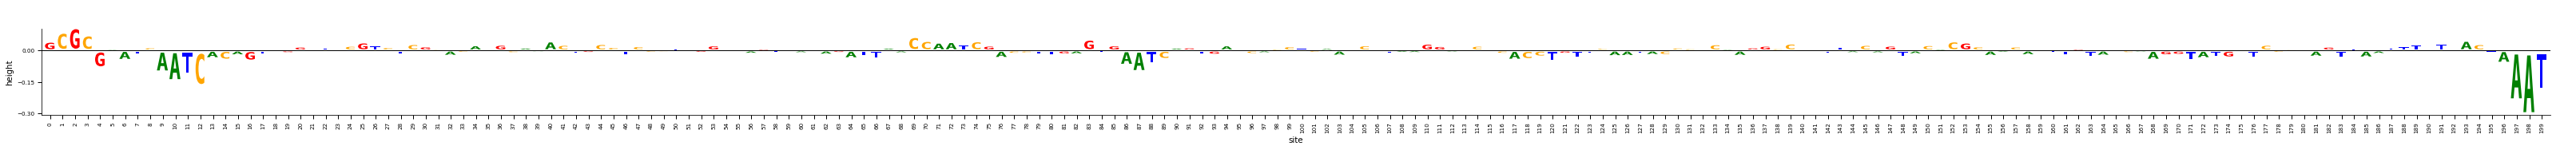

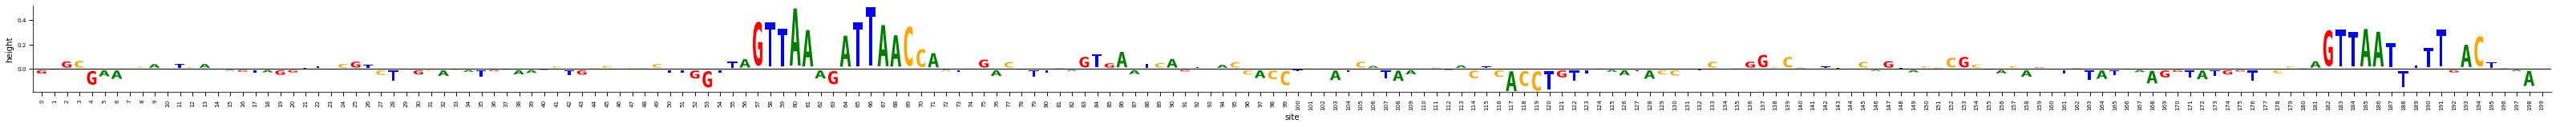

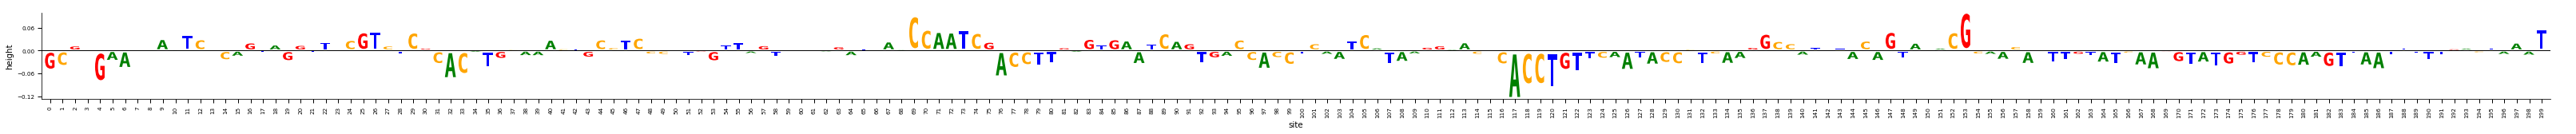


------------------------------ Sequence 8 ------------------------------



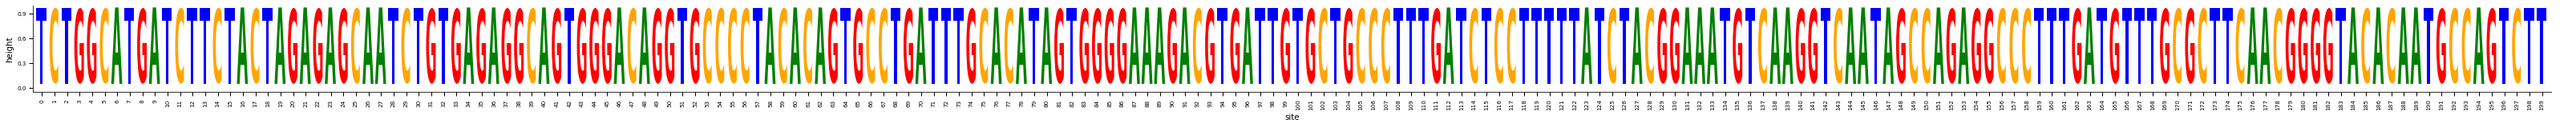

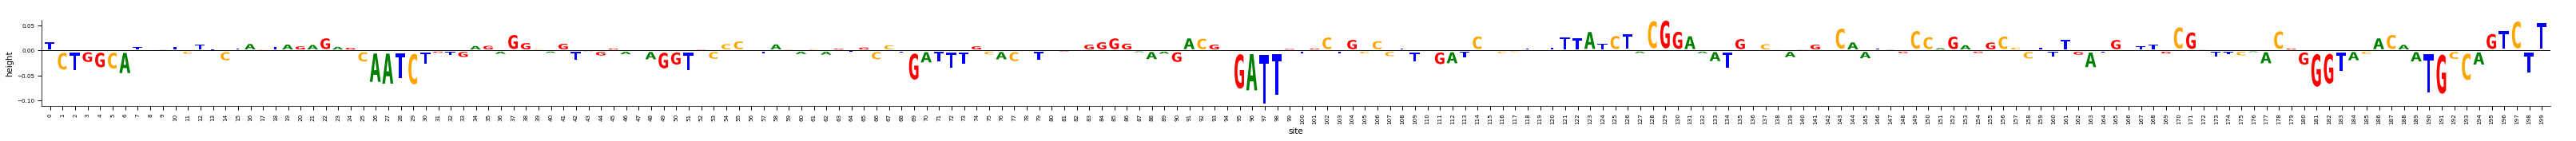

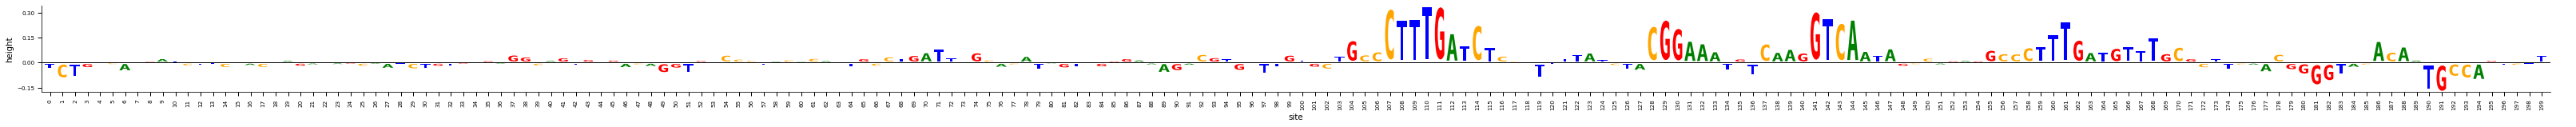

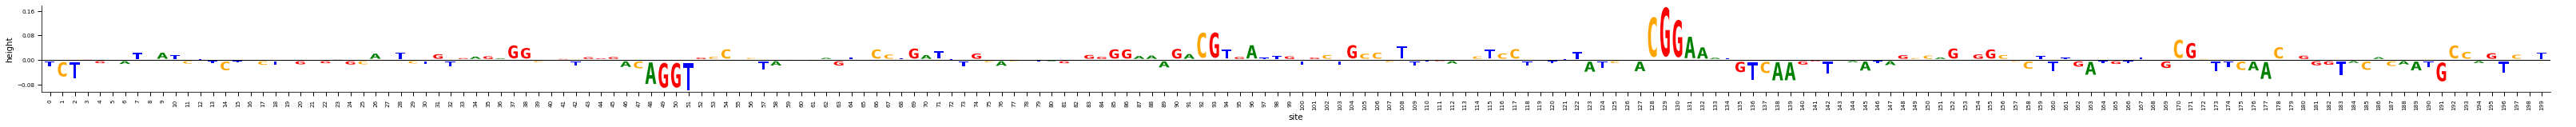


------------------------------ Sequence 9 ------------------------------



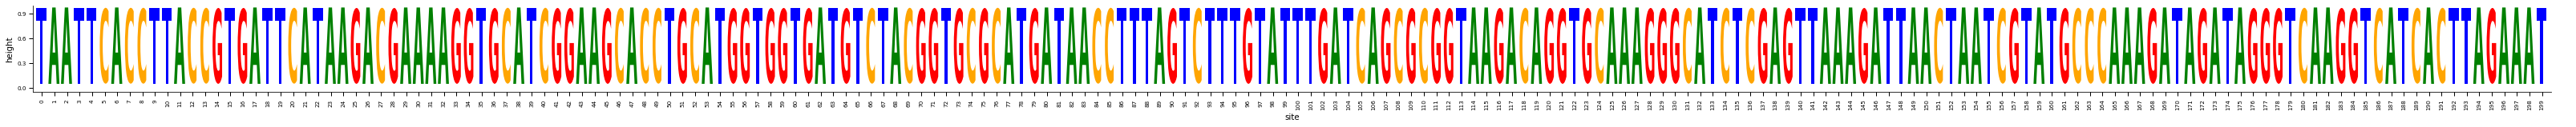

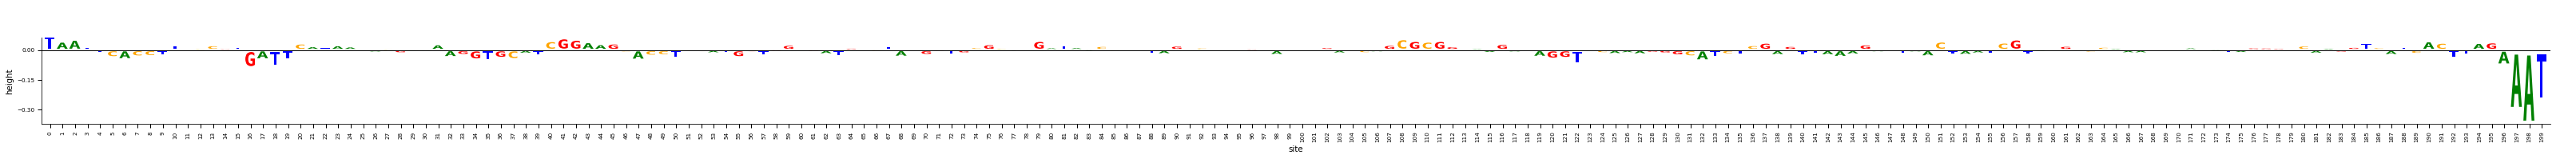

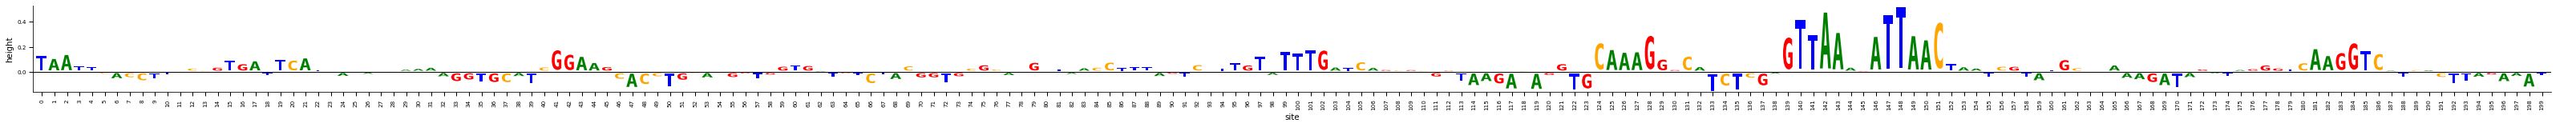

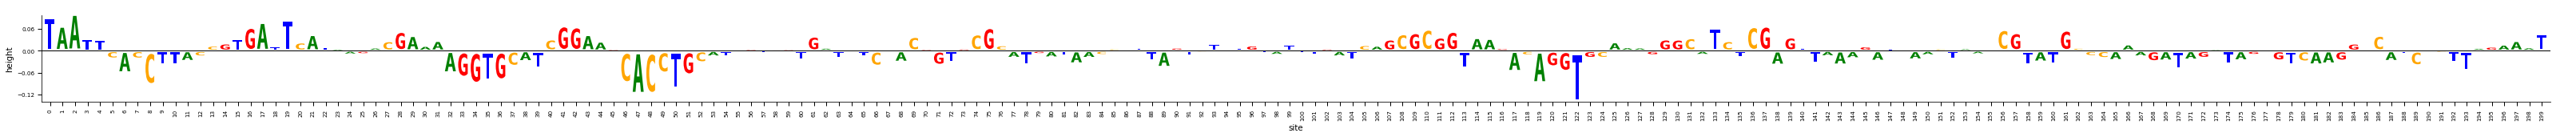


------------------------------ Sequence 10 ------------------------------



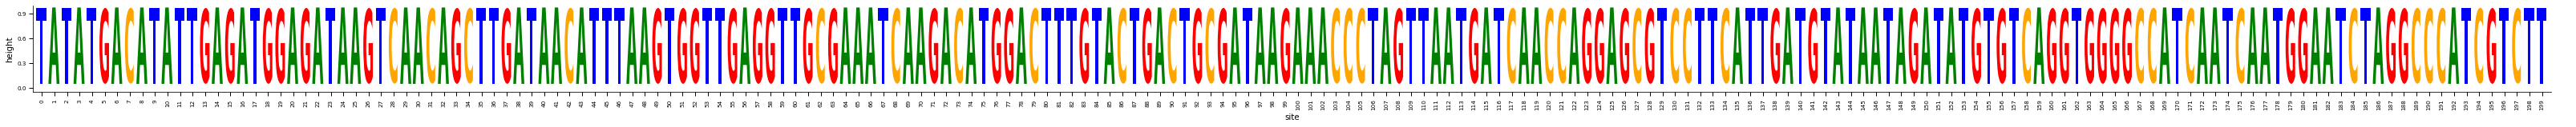

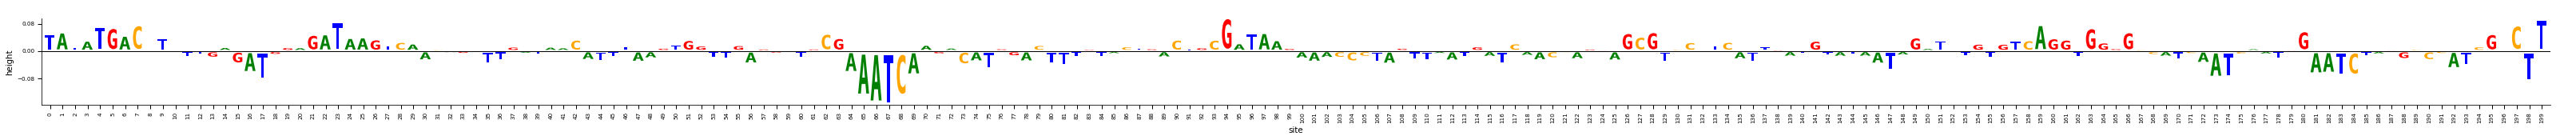

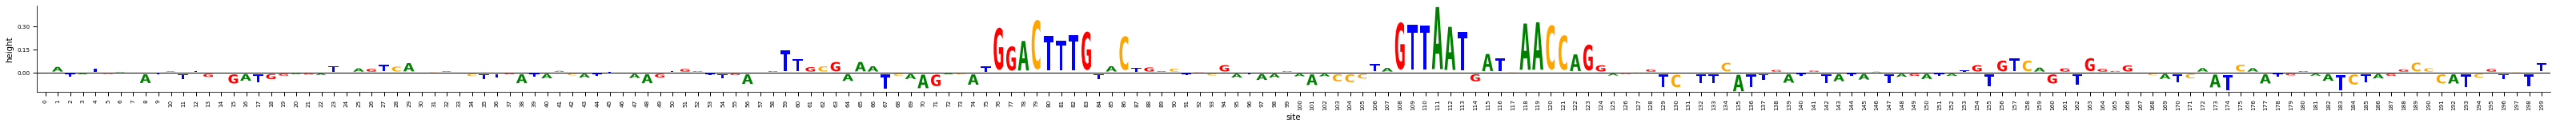

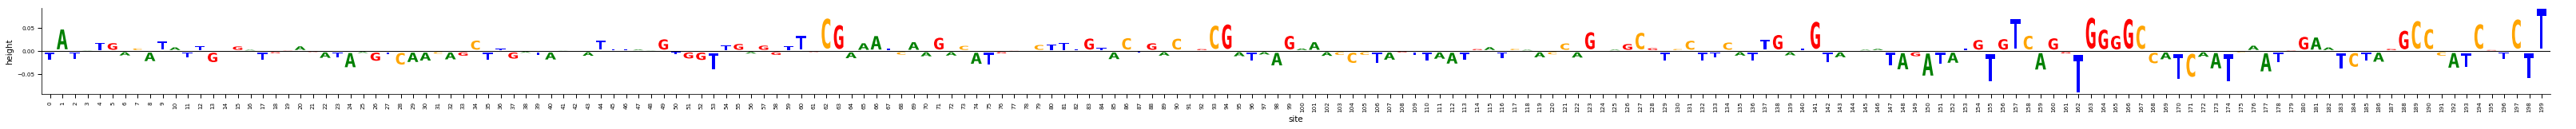


------------------------------ Sequence 11 ------------------------------



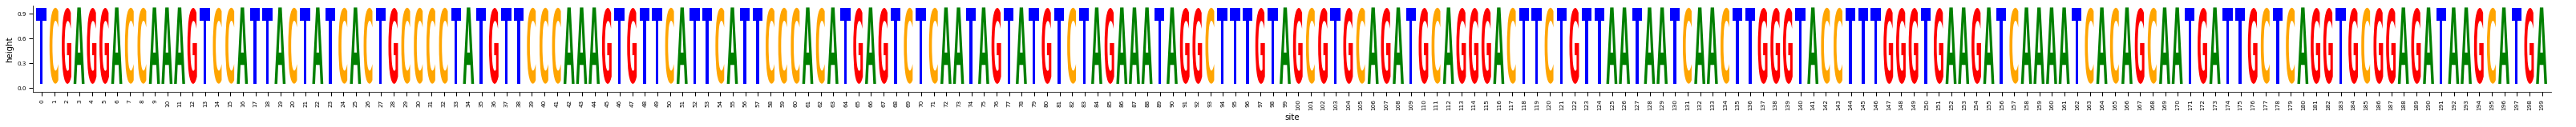

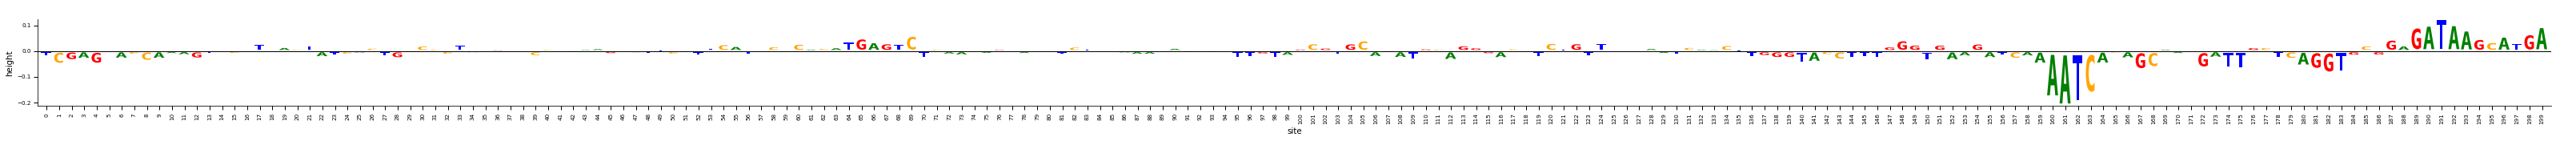

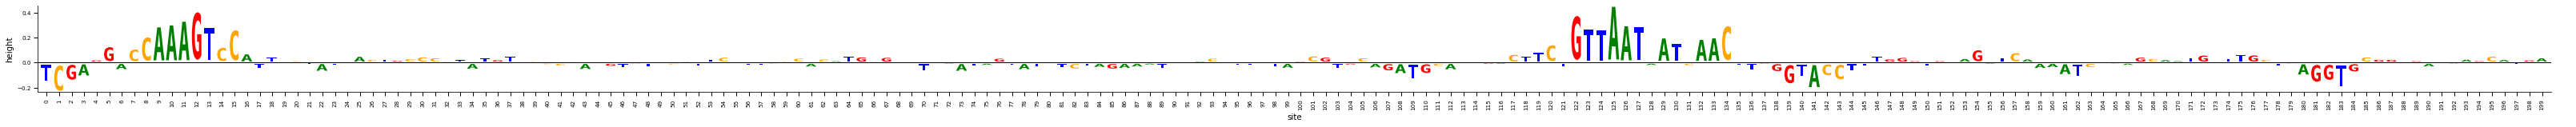

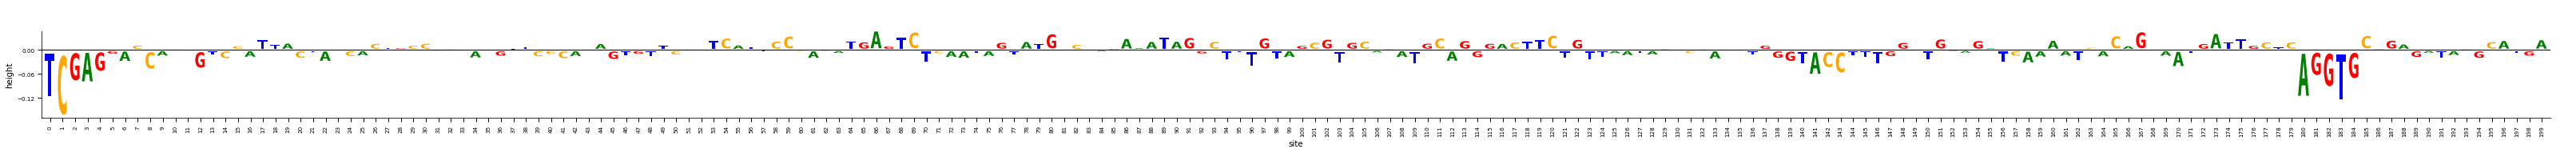


------------------------------ Sequence 12 ------------------------------



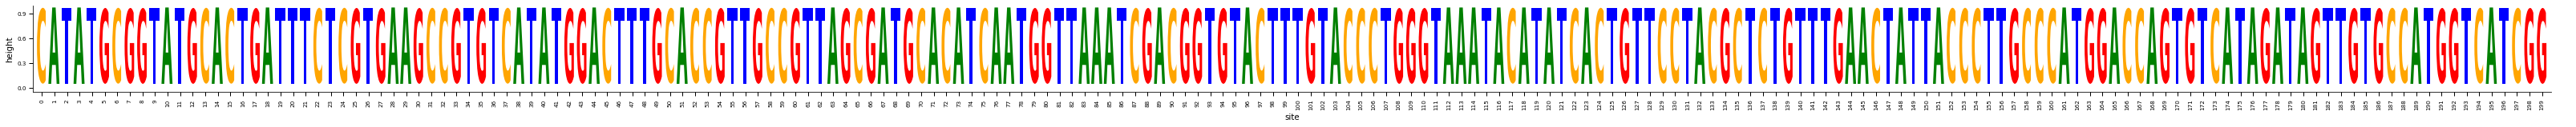

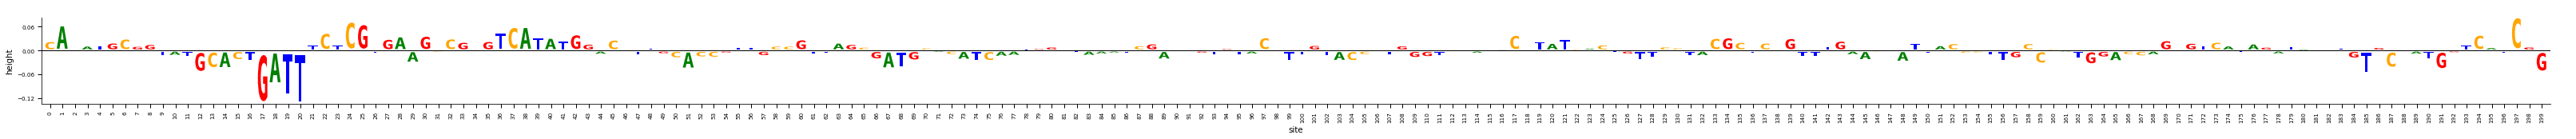

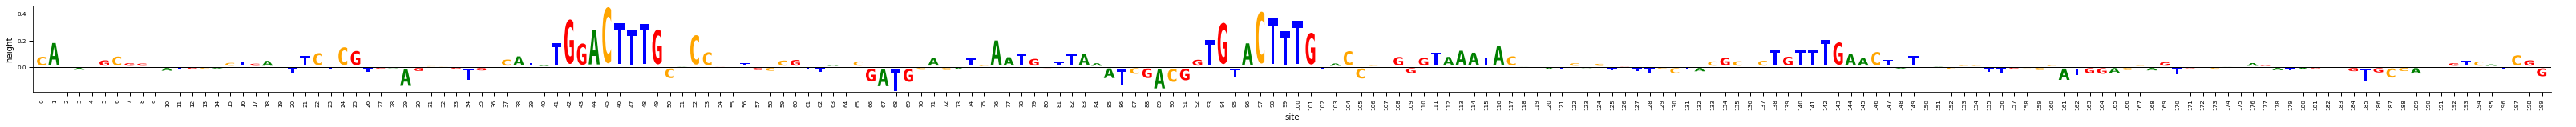

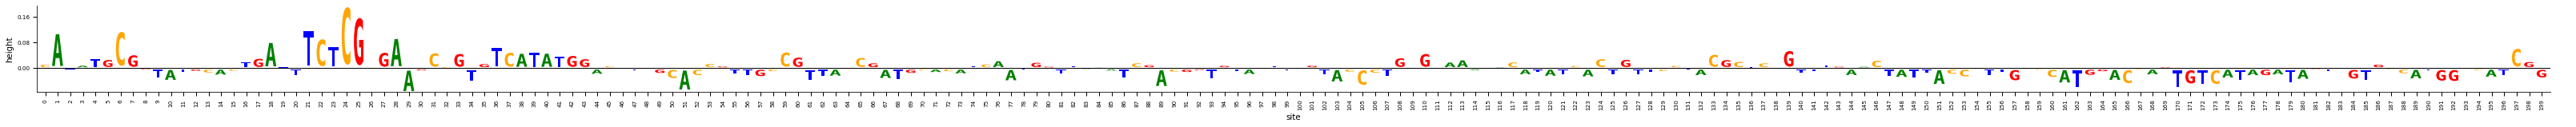


------------------------------ Sequence 13 ------------------------------



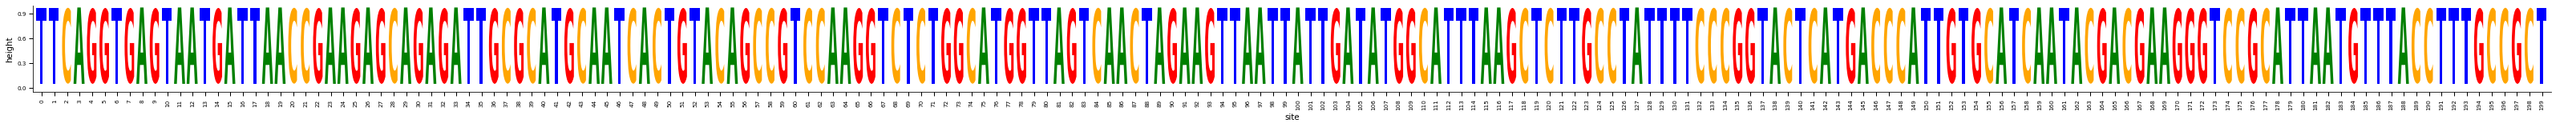

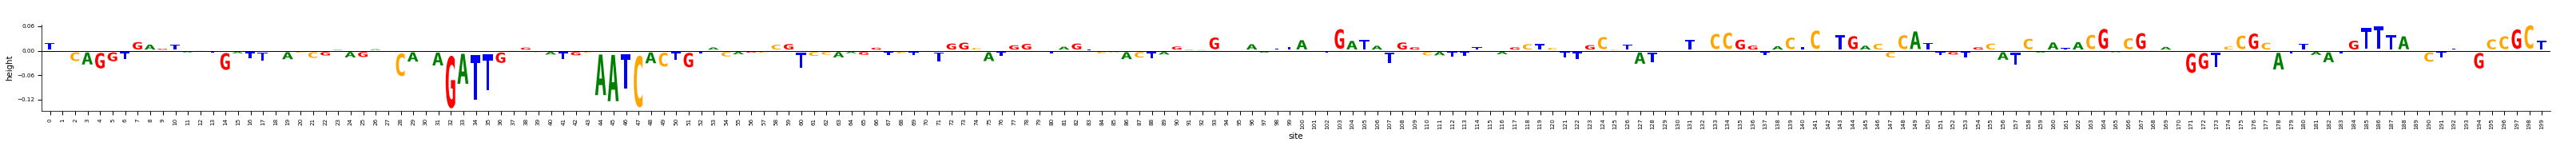

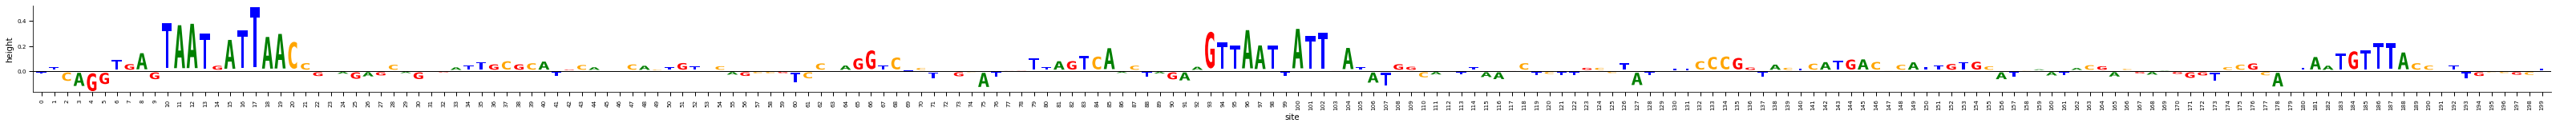

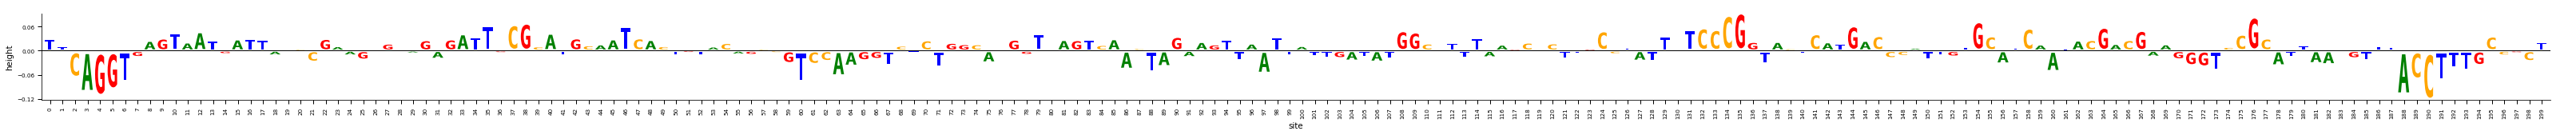


------------------------------ Sequence 14 ------------------------------



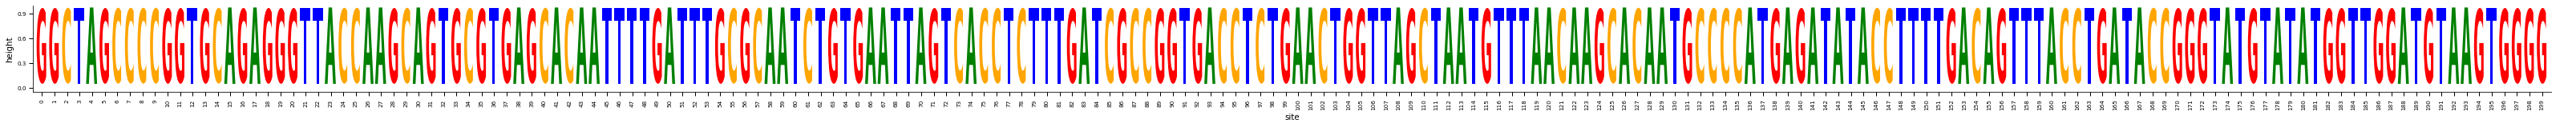

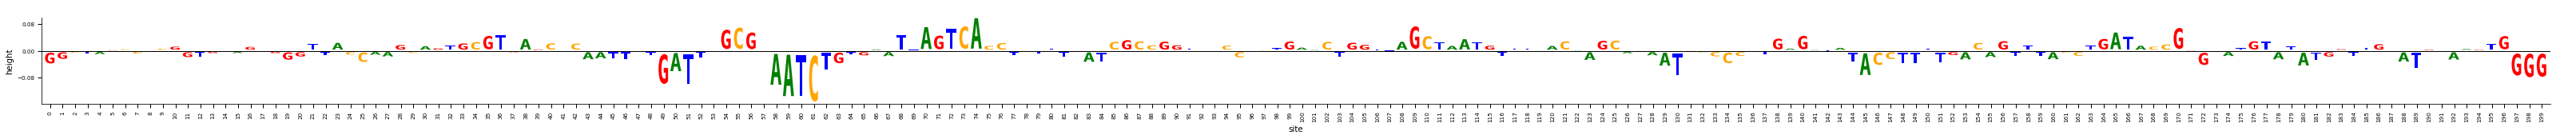

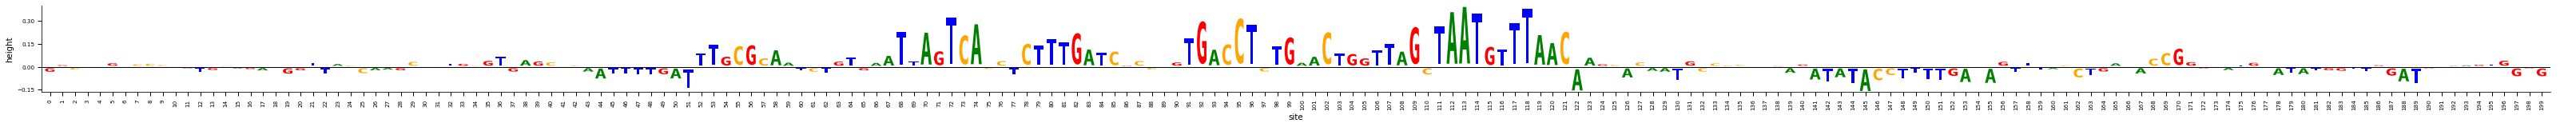

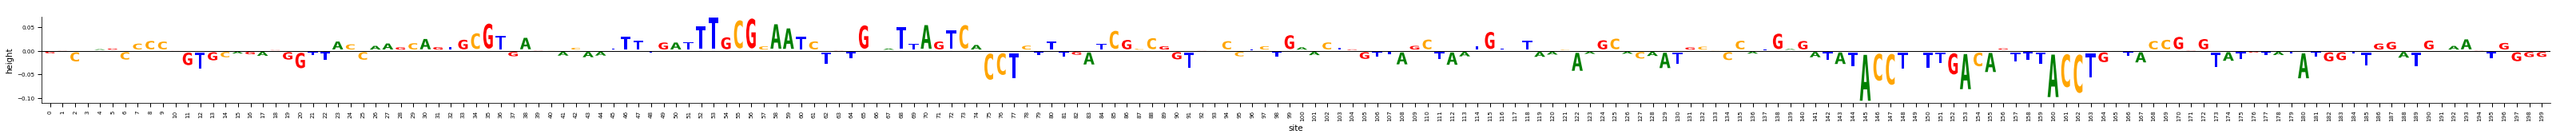


------------------------------ Sequence 15 ------------------------------



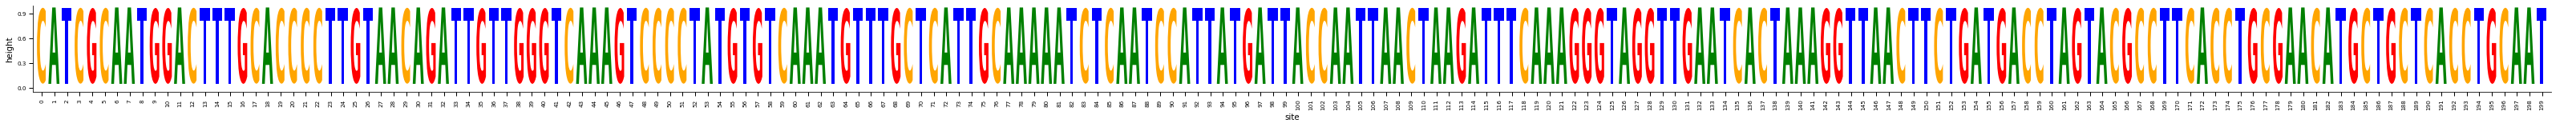

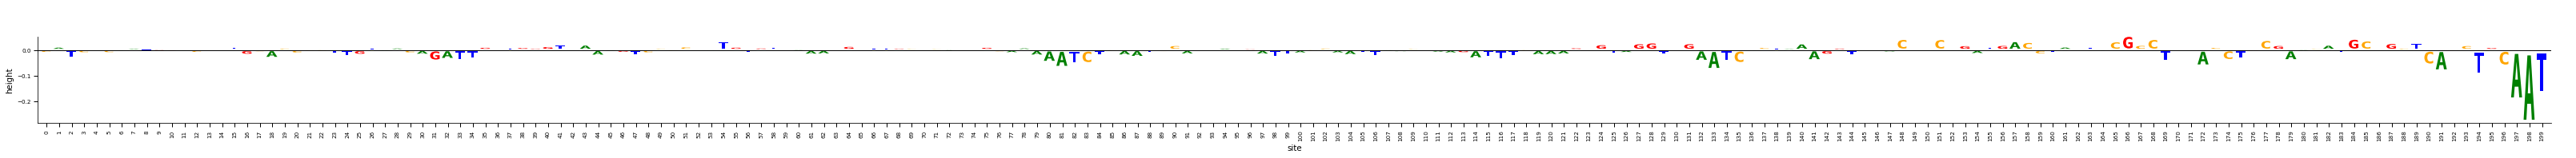

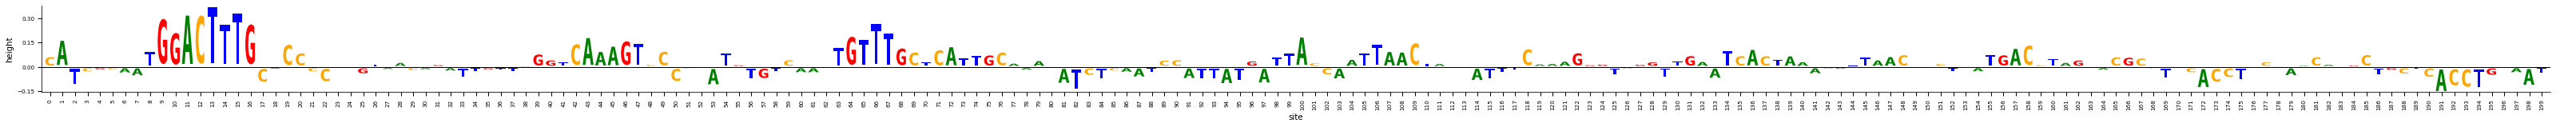

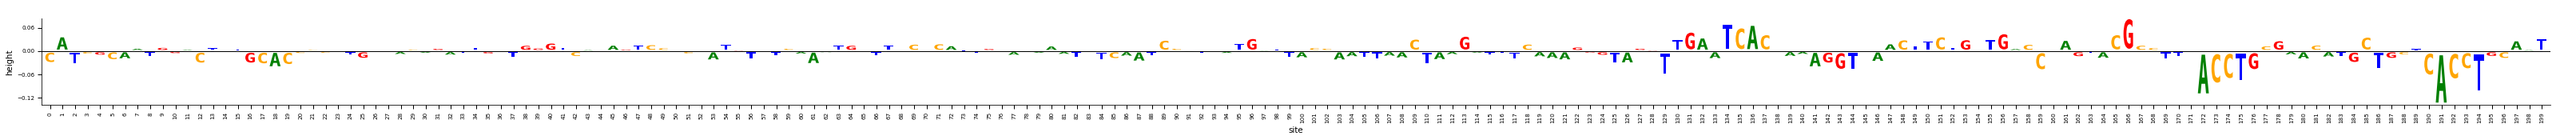


------------------------------ Sequence 16 ------------------------------



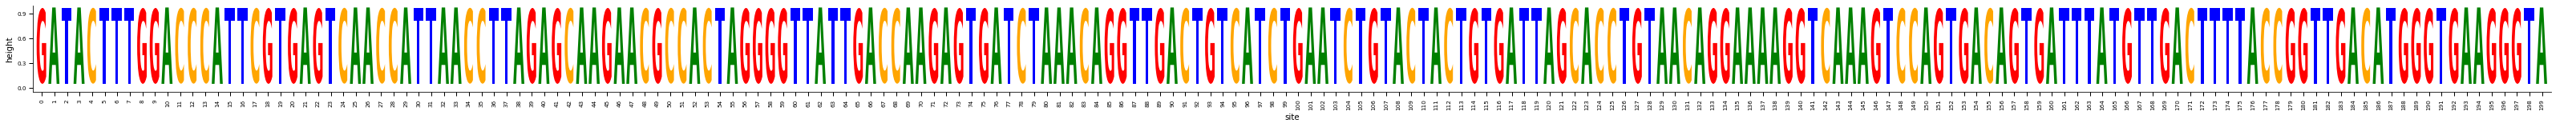

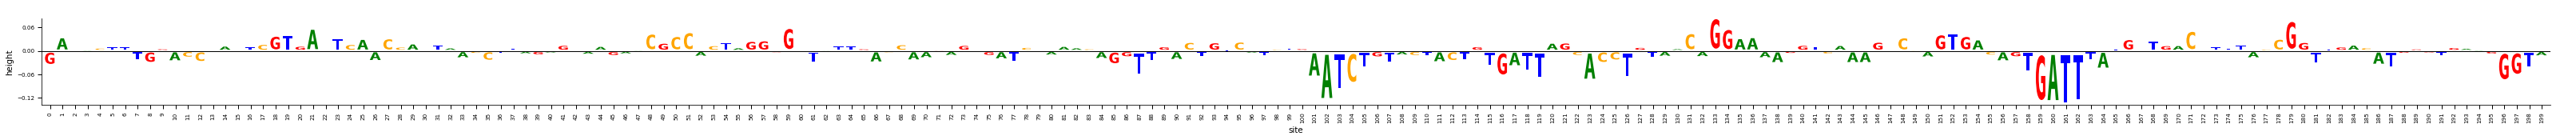

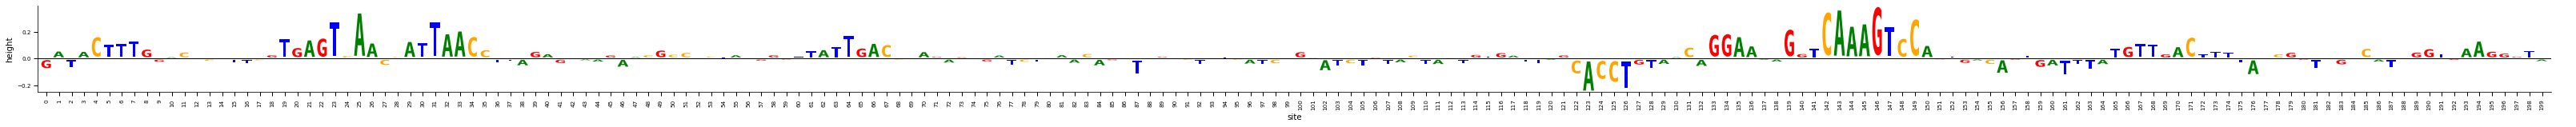

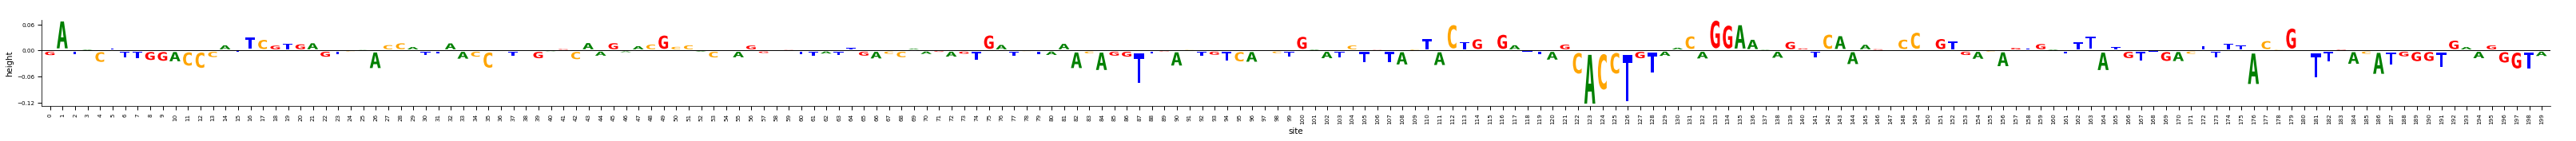


------------------------------ Sequence 17 ------------------------------



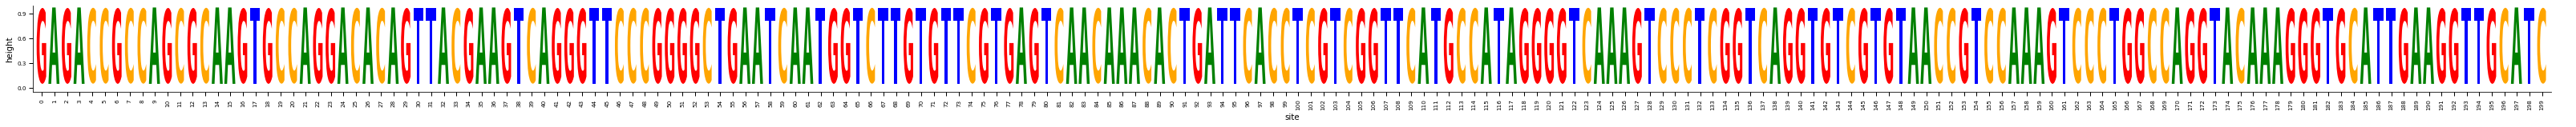

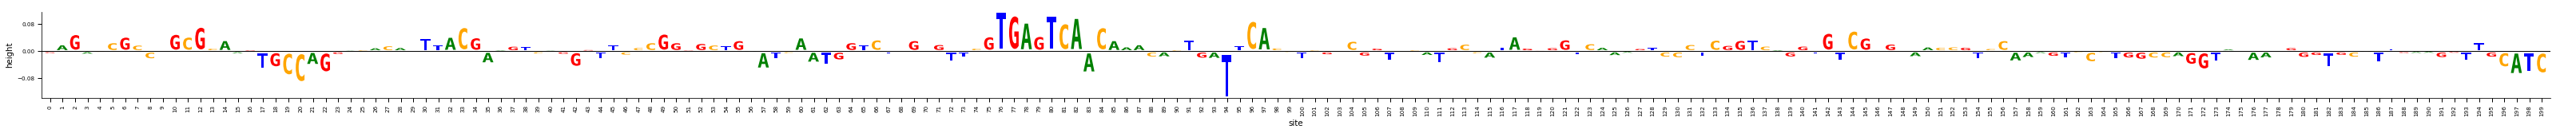

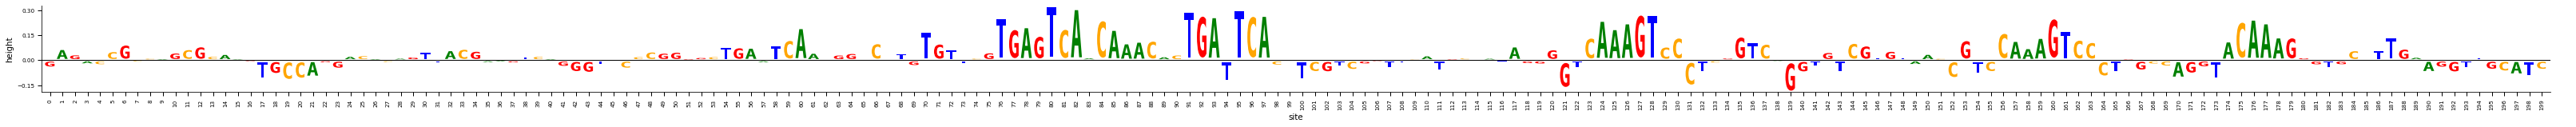

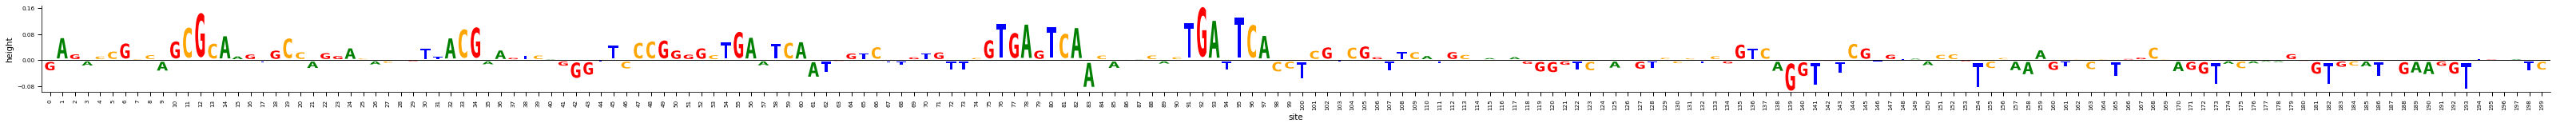


------------------------------ Sequence 18 ------------------------------



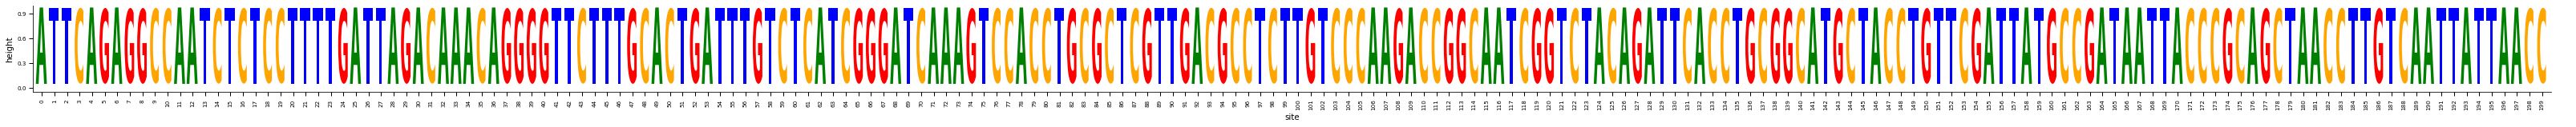

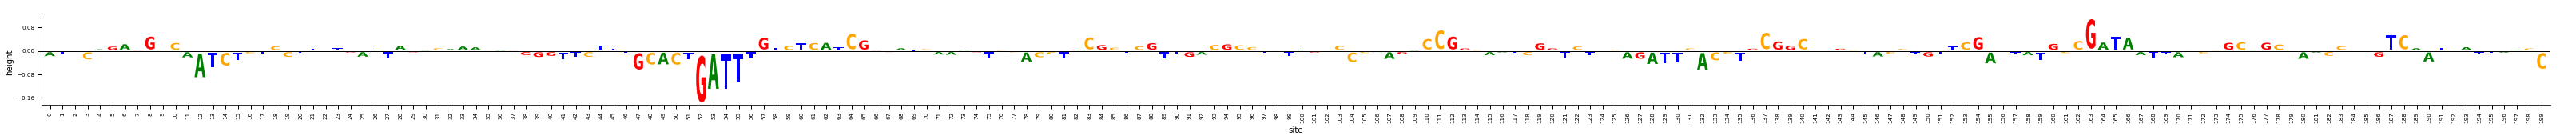

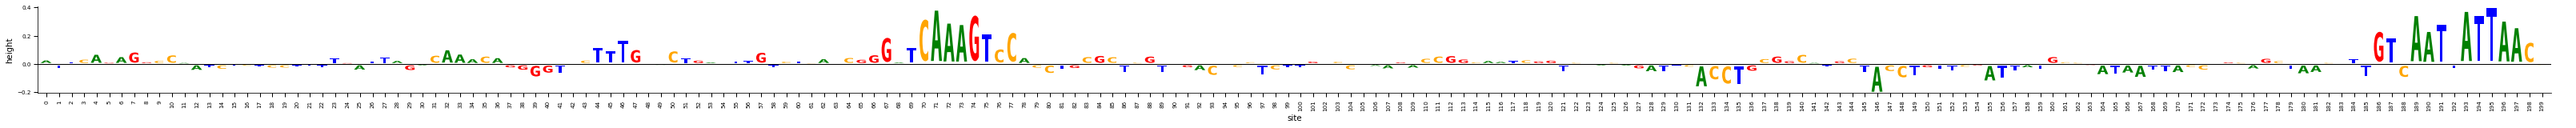

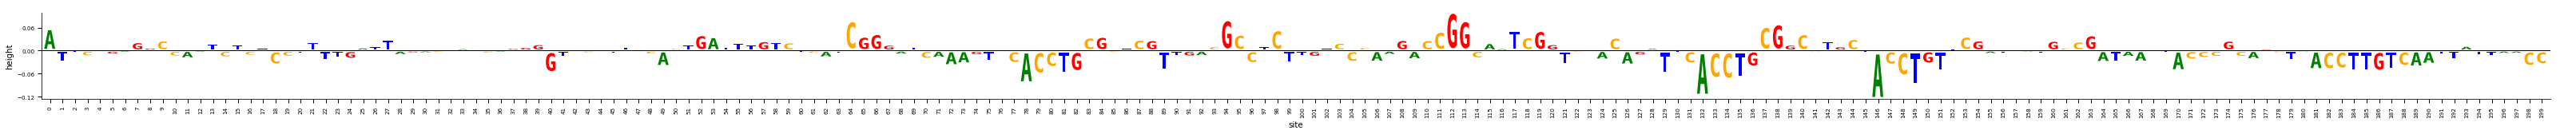


------------------------------ Sequence 19 ------------------------------



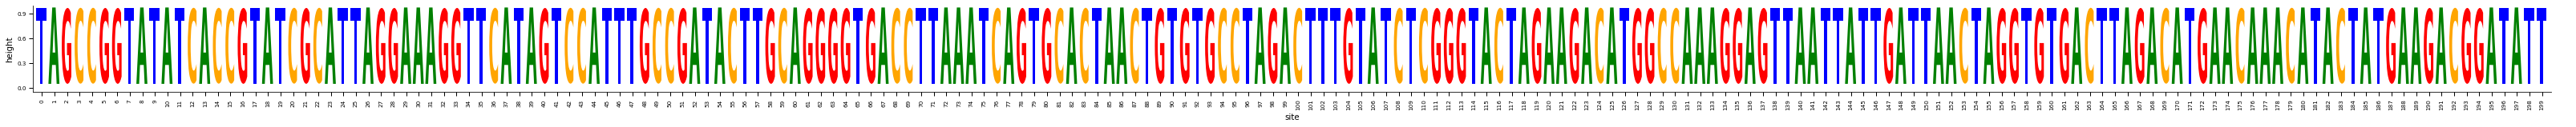

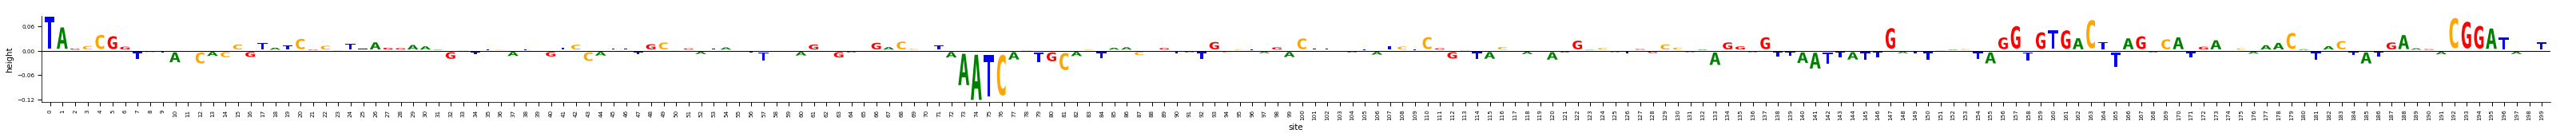

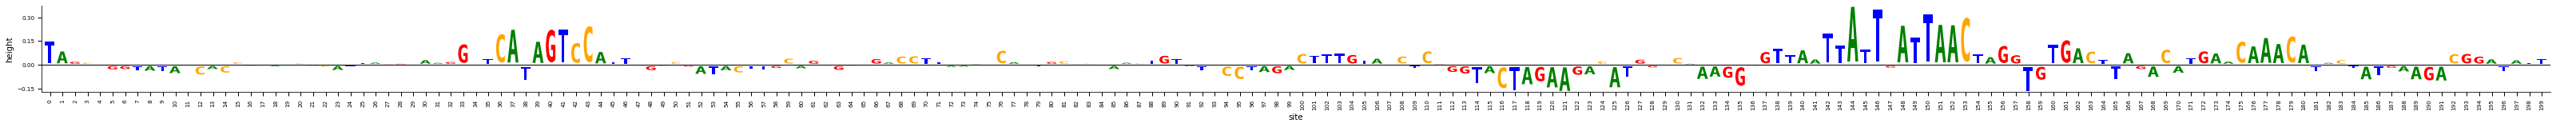

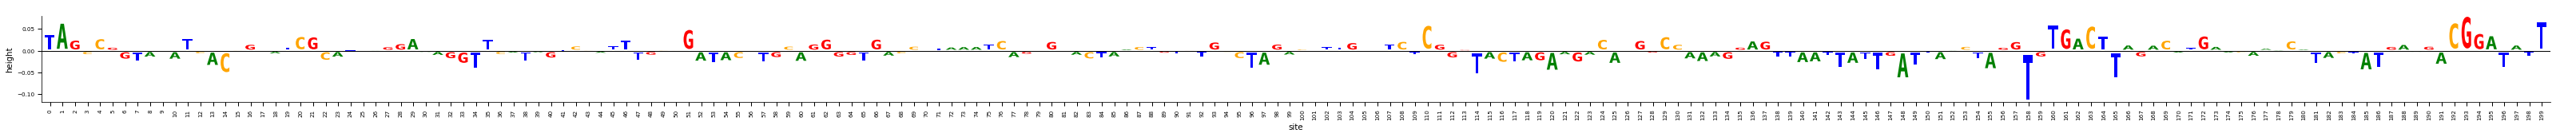


------------------------------ Sequence 20 ------------------------------



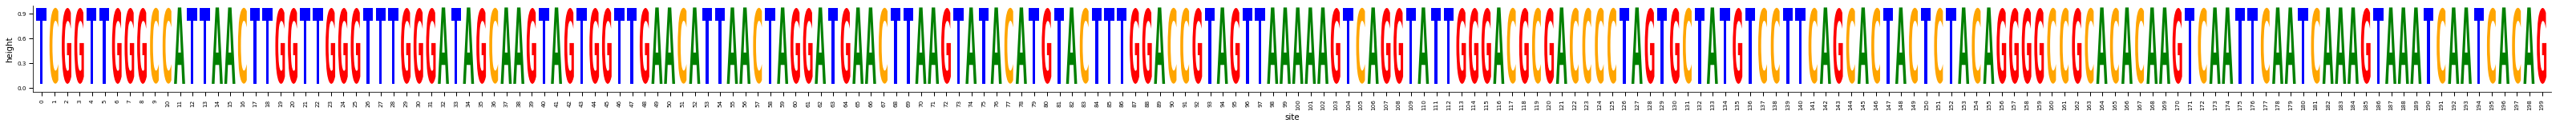

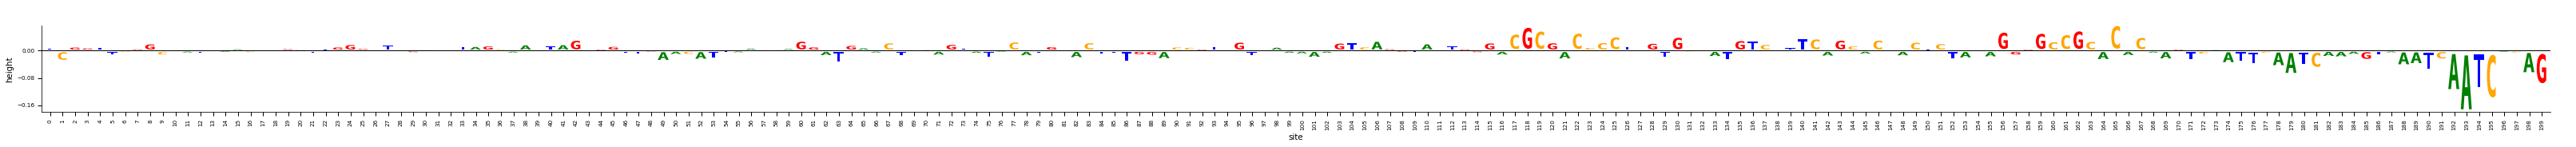

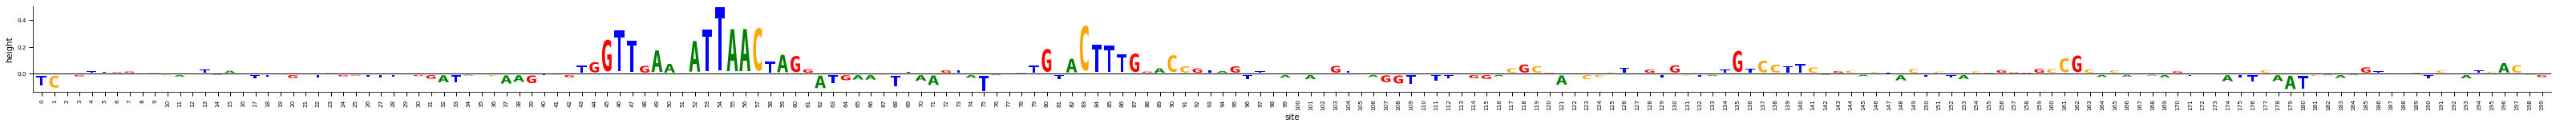

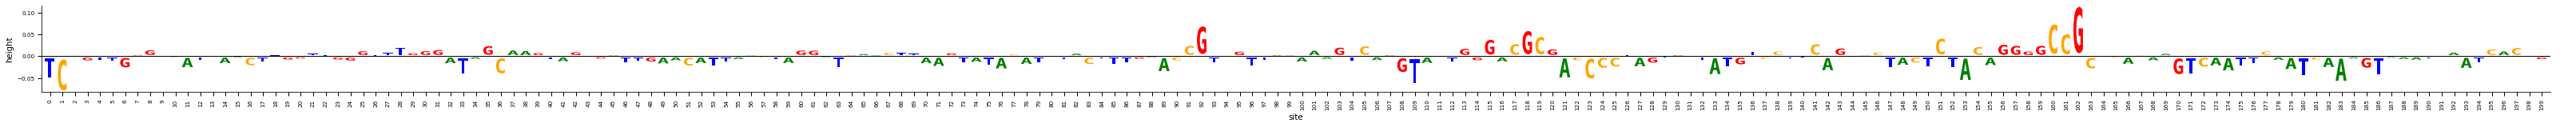

In [62]:
for i in range(batch.shape[0]):
    print('')
    print(f'------------------------------ Sequence {i+1} ------------------------------')
    print('')
    matrix = batch[i, ...].detach()
    y_max = matrix.max()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=0.8)
    plt.show()
    for j in range(3):
        matrix = all_salient_maps[j][i, ...]
        y_max = matrix.max()
        fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=0.65, widthscale=0.8,
                          axisfontscale=0.6, heightscale=0.8)
        plt.show()